# Components

In {term}`gdsfactory`, we create components and then connect them together to create larger, more complicated designs. Components can be simple shapes or more complex constructions, for example, containing references to other components. They usually have ports which allow you to connect the component to other components in GDS Factory. When ports are defined, the translation and aligning of ports to each other is taken care of for you automatically.

## Elements of a Component

Components can be made up of polygons, references, ports and (optionally) labels.

Most basically, to start building a component, you need to create the ``Component`` object:

In [78]:
import gdsfactory as gf

c = gf.Component()

```{tip}

Components have a series of convenience functions to help you visualize them in Jupyter notebooks. For example:

* [``plot``]()
* [``plot_holoviews``]()
* [``plot_jupyter``]()
* [``plot_klayout``]()
* [``plot_matplotlib``]()
* [``plot_netlist``]()
* [``plot_netlist_flat``]()
* [``plot_widget``]()

Some of these are aliases for each other. For example, ``plot`` will by default use ``plot_klayout``, and could be changed using a keyword argument to use ``matplotlib``. In the below examples, for formatting, we'll be explicit. But **the recommended plot function is ``plot``**, which will display an interactive klayout widget in Jupyter notebooks.
```

### Polygons

Polygons are the lowest building block of components. They are simply an ordered list of vertices, each adjacent pair of vertices defining a line that does not cross any other lines within the shape (although overlapping of parallel lines is allowed, and vertices can lie upon other lines).


### References

References point to an existing geometry instead of creating a new one. That geometry can be a component defined by a polygon, a more complex parameterized component (called a parametric cell), or even a hierarchical component (cell with component nesting). They save memory because the the core geometry is only defined once but is referenced many times. These references can be translated, rotated and placed anywhere independently, but those operations are all applied to the base instance. 

For example, if you had a component that used the same taper on all of its inputs and outputs, instead of repeatedly defining the same taper, it would be good to create the taper only once and then reference it and rotate it (if required) as many times as you need for the higher-level component. By using references you can draw on a bank of components to create more complex components without using up as much memory. 

This follows the pattern used in GDS files, where a cell is defined once and then referenced many times across a design.

### Ports

Ports are placed at the inputs and outputs of components. 

In a hierarchical component (one composed of many other components), you'll place it at the interconnect of the compound component and not the intermediate ones. You must specify the direction the port is facing (generally either into or out of the component). You can also specify the width of the port, although it is generally just the width of the input or output of the component it is attached to.

### Labels

You can also add labels to your component to convey information not otherwise included. These labels will be seen in the gds file as well as in ``gdsfactory``. 

A label is added to a component using the function [``add_label``](https://gdsfactory.github.io/gdsfactory/notebooks/00_geometry.html?highlight=add_label#labels), to which you pass the label text and location where it should be in the component, as shown below:

```python
c.add_label(text="LABEL TEXT", position=c.center)
```

## Components from polygons

In gdsfactory, polygons can be used to build up a component's geometry. Polygons are defined by their (ordered) vertices and the GDS layer on which they lie. For components with more complex functions, i.e. not just passive components, several polygons laying on more than one layer may be needed to define the component. You can specify what parts of your component are on which layer when adding the polygon to the component. Components track the number of polygons they contain.

As an example, let us create a taper using polygons. We create polygons by passing a list of tuples (the coordinates) to the ``points`` keyword argument. When specifying points we need to do this in an ordered, circular fashion as shown below. The initial point should not be repeated as the last point, as it is inferred that the polygon is closed.

*(This script is complete, it should run "as is")*

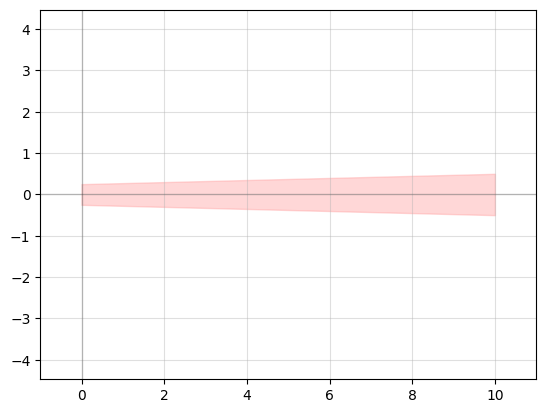

In [2]:
import gdsfactory as gf

# Create a component containing a polygon for the taper
# This will be referenced in the final component
taper = gf.Component()

t_length = 10
t_width_in = 0.5
t_width_out = 1

# Add polygon defining the taper waveguide shape
taper.add_polygon(
    points=[
        (0, -t_width_in/2),
        (0, t_width_in/2),
        (t_length, t_width_out/2),
        (t_length, -t_width_out/2)
    ], 
    # GDS layers are tuples of ints, but if we use only one number it assumes 
    # we've provided the layer number and that the other number, the datatype, 
    # is 0.
    layer=1,
)

# Visualize the taper
taper.plot_matplotlib()

## Translation and rotation of polygons

Polygons can also be translated and rotated.

*(This script is complete, it should run "as is")*

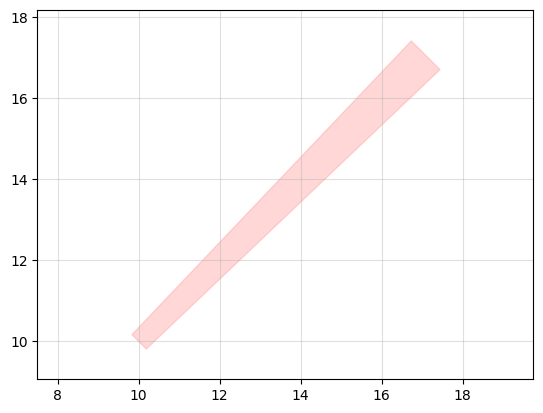

In [25]:
import gdsfactory as gf

# Create a component containing a polygon for the taper
# This will be referenced in the final component
taper = gf.Component()

t_length = 10
t_width_in = 0.5
t_width_out = 1

# Add polygon defining the taper waveguide shape
poly = taper.add_polygon(
    points=[
        (0, -t_width_in/2),
        (0, t_width_in/2),
        (t_length, t_width_out/2),
        (t_length, -t_width_out/2)
    ], 
    # GDS layers are tuples of ints, but if we use only one number it assumes 
    # we've provided the layer number and that the other number, the datatype, 
    # is 0.
    layer=1,
)

poly.rotate(45)
poly.move((10, 10))
          
# Visualize the taper
taper.plot_matplotlib()

## Boolean operations

gdsfactory comes with a variety of functions that can help you manipulate the geometry of your component, allowing you to more easily create many different shapes. For example, there are Boolean operators you can use to combine different geometries, meaning that you can subtract shapes from each other, merge them together, or XOR them. 

To use these operations, you specify the two groups of pieces of the geometry that will be involved in the operation, the operation itself, and the target layer (where to place the resulting geometry):

```python
gf.geometry.boolean(
    A=[components_a], B=[components_b], operation="A-B", layer=1
)
```

The accepted operations are: 

* ``"and"``
* ``"not"``
* ``"or"``
* ``"xor"``
* ``"A-B"`` (equivalent to "not")
* ``"B-A"``
* ``"A+B"`` (equivalent to "or")

*(This script is complete, it should run "as is")*

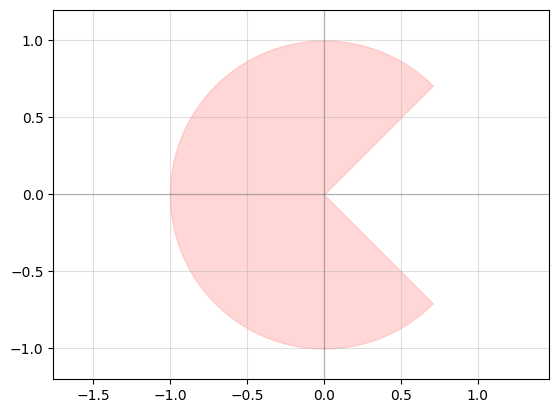

In [17]:
import gdsfactory as gf
import numpy as np

t = np.linspace(0, 2*np.pi, 100)
x = np.cos(t)
y = np.sin(t)

circle = gf.Component()
circle.add_polygon(points=(x, y), layer=1)

triangle = gf.Component()
triangle.add_polygon(points=((0, 0), (1, -1), (1, 1)), layer=1)

pacman = gf.geometry.boolean(A=circle, B=triangle, operation="A-B", precision=1e-6, layer=1)

# Plot the originals and the result
c = gf.Component("boolean_subtraction")
c.add_ref(pacman) # we'll talk about references later
c.plot_matplotlib()

## Parametric cells

To parameterize this process to make tapers of different dimensions, or to repeatedly use the same geometry without redefining the shape and vertices every time, we can write a function that returns a component. This is called a parametric cell. 

In addition to calculating the location of the points for us, it caches the input parameters and its corresponding output geometry so that any subsequent call with the same parameters will return the geometry without rebuilding it. In order to enable this functionality, you must use the ``@gf.cell`` decorator.

```{warning}

If you're developing in a notebook, because of caching, if you modify the contents of a cell and call it again without changing the parameters, your new code won't be run. You need to clear ``gdsfactory``'s cache using ``gf.clear_cache()``.
```

Writing cell functions is a good way to create a library of reusable components for your circuits. Another fantastic benefit of writing cells is, if you type-hint them, gdsfactory will automatically validate arguments types.

Let's create a parametric cell for tapers named ``taper()``. We'll be able to create new tapers by simply calling 

```python
taper_component = taper()
```

*(This script is complete, it should run "as is")*

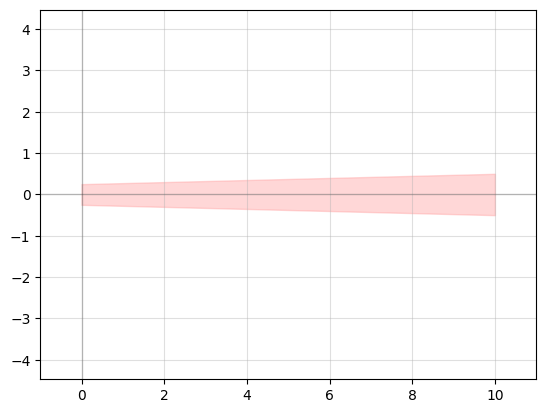

In [3]:
import gdsfactory as gf

@gf.cell
def taper(length: float = 10, width_in: float = 0.5, width_out: float = 1.0):
    # Create a component containing a polygon for the taper
    c = gf.Component()

    # Add polygon defining the taper waveguide shape
    c.add_polygon(
        points=[
            (0, -width_in/2),
            (0, width_in/2),
            (length, width_out/2),
            (length, -width_out/2)
        ], 
        layer=1,
    )

    # Return the constructed component
    return c

# Visualize the taper
t = taper()
t.plot_matplotlib()

### Shapes and generic cells

Just like we've created a new cell called ``taper()``, gdsfactory comes with a [library of basic cells](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html) you can use. These can help you create more complex components more quickly, without having to calculate the position of every polygon point.

Some of the most useful ones include:

* [``gf.components.rectangle``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#rectangle)
* [``gf.components.ellipse``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#ellipse)
* [``gf.components.circle``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#circle)
* [``gf.components.ring``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#ring)
* [``gf.components.bend_circular``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#bend-circular)
* [``gf.components.bend_euler``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#bend-euler)
* [``gf.components.tapers``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#tapers) (I know we just made one)
* [``gf.components.text``](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_shapes.html#text)

## Adding ports

Ports are placed at the inputs and outputs of components and cells--places where it should line up with other components. You must specify the direction the port is facing (generally outwards, away from the component). You can also specify the width of the port, which is generally just the width of the input or output of the component it is attached to.

Ports make it easier to attach components together. As you make more complex designs and start connecting different components together, ports will help to automatically move, rotate, and align components together by matching up their respective ports.

Let's expand our taper from earlier by adding ports. (Note that it's common for *all* ports to point away from the component, instead of towards it.)

*(This script is complete, it should run "as is")*

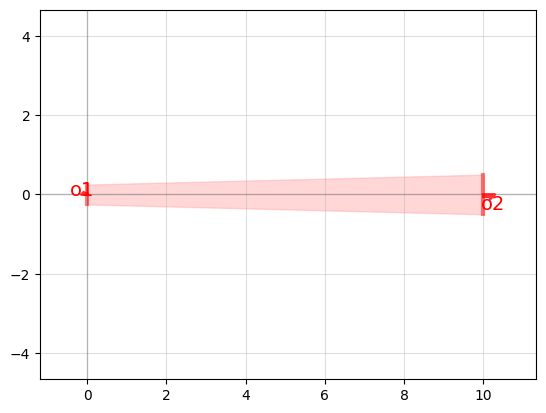

In [21]:
import gdsfactory as gf

@gf.cell
def taper(length: float = 10, width_in: float = 0.5, width_out: float = 1.0):
    # Create a component containing a polygon for the taper
    c = gf.Component()

    # Add polygon defining the taper waveguide shape
    c.add_polygon(
        points=[
            (0, -width_in/2),
            (0, width_in/2),
            (length, width_out/2),
            (length, -width_out/2)
        ], 
        layer=1,
    )

    # Add ports to the component
    ports = [
        gf.Port("o1", orientation=180, center=(0, 0), width=width_in, layer=(1, 0), port_type="optical"),
        gf.Port("o2", orientation=0, center=(length, 0), width=width_out, layer=(1, 0), port_type="optical"),
    ]
    c.add_ports(ports)

    # Return the constructed component
    return c

# Visualize the taper
t = taper()
t.plot_matplotlib()

And there we've added ports that can be used for translating and aligning this component to other components as part of a larger circuit.

:::{note}

gdsfactory's port naming convention is: 

* ports are numbered clock-wise starting from the bottom left corner
* optical ports are prefixed with "o"
* electrical ports are prefixed with "e"
* numbering is 1-indexed, not 0-indexed
:::

## Components using references

As shown previously, ``gdsfactory`` defines your component once in memory. Any time you then use it, you are adding a reference to the same component. A reference does not contain any geometry, but is essentially a pointer to an existing component. There is no limit to the number of references you can have to a component.

The GDSII specification is built around the use of references, so gdsfactory also uses them (with the ``Component.add_ref()`` function or the ``<<`` operator).

In the previous example, we created and parameterized the geometry of a taper. We'll now include that taper cell  in a 2x2 multimode interferometer (MMI) by using references. We'll learn about MMI's later, but for now just know that they have a wide (and therefore multimodal) waveguide section with inputs and outputs on each side, where we'll attach our tapers.

By using references to add tapers to our MMI, we could easily change the parameters of all four tapers without having to redraw each one individually.

Let's make a function that returns an MMI component. Right off the bat, we'll make it a parametric component. We'll call it ``mmi2x2()``. It will take as arguments the width of the multimode section, the length of the multimode section, as well as parameters for the tapers. It will return an MMI component with four tapers attached to it.

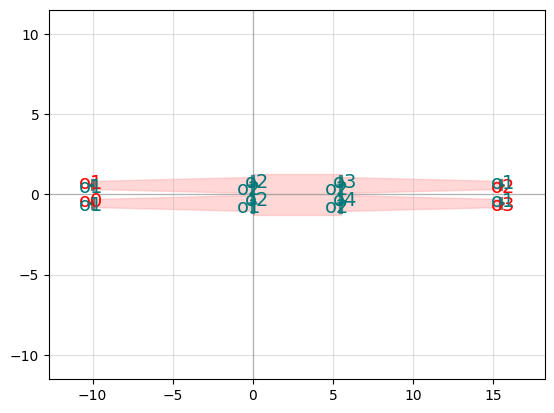

In [58]:
import gdsfactory as gf

@gf.cell
def mmi2x2(
    length: float = 5.5,
    width: float = 2.5,
    gap: float = 0.125,
):
    # Determine the shape of the taper we'll use
    taper_length = 10
    taper_width_in = 0.5
    taper_width_out = 1
    taper_c = taper(length=taper_length, width_in=taper_width_in, width_out=taper_width_out)

    # Add the MMI body
    mmi = gf.Component()
    rect = mmi.add_ref(gf.components.rectangle(size=(length, width), layer=1, port_type=None))
    rect.move((0, -width/2))

    # Add ports to the MMI body
    port_width = taper_width_out
    port_center = gap / 2 + taper_width_out / 2
    mmi.add_ports([
        gf.Port('o1', orientation=180, center=(0, -port_center), width=port_width, layer=(1, 0), port_type="optical"),
        gf.Port('o2', orientation=180, center=(0, port_center), width=port_width, layer=(1, 0), port_type="optical"),
        gf.Port('o3', orientation=0, center=(length, port_center), width=port_width, layer=(1, 0), port_type="optical"),
        gf.Port('o4', orientation=0, center=(length, -port_center), width=port_width, layer=(1, 0), port_type="optical"),
    ])

    c = gf.Component()
    # We can use add_ref
    mmi_ref = c.add_ref(mmi)
    # or we can use the left shift operator as shorthand
    taper_refs = [c << taper_c for _ in range(4)]

    # Move the tapers into position
    for i, port in enumerate(["o1", "o2", "o3", "o4"]):
        taper_refs[i].connect(port="o2", destination=mmi_ref.ports[port])

    # The composed component needs to have just its ports alone exposed
    for i, ref in enumerate(taper_refs):
        c.add_port(name=f"o{i}", port=ref.ports["o1"])
    c.auto_rename_ports() # for consistency

    return c

gf.clear_cache()
mmi2x2().plot_matplotlib()

For simpler components, you may find it easier to just do the math and calculate how different geometries fit together yourself. But for more complex components, it's often easier to use references to attach other components together. It also makes swapping out or modifying components easier, because you won't have to redo the math.

Below is an example of calculating inline where to place tapers without connecting its ports.

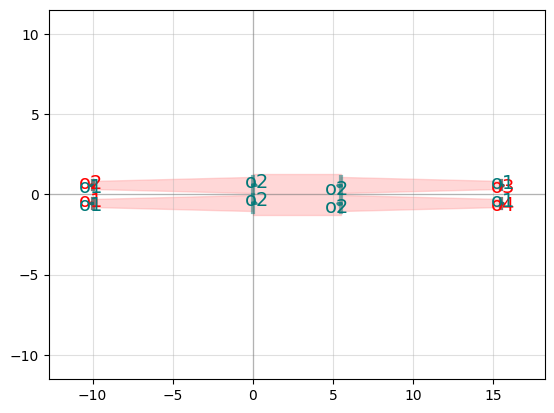

In [61]:
@gf.cell
def mmi2x2(
    length: float = 5.5,
    width: float = 2.5,
    gap: float = 0.125,
):
    c = gf.Component()

    # Add the MMI body
    rect = gf.components.rectangle(size=(length, width), layer=1, port_type=None)
    rect_ref = c.add_ref(rect)
    rect_ref.move((0, -width/2))

    # We'll have to do some math to figure out where to put the tapers
    taper_length = 10
    taper_width_in = 0.5
    taper_width_out = 1
    taper_c = taper(length=taper_length, width_in=taper_width_in, width_out=taper_width_out)
    
    tapers = [
        c.add_ref(taper_c, origin=(-(taper_length), (taper_width_out + gap)/2), rotation=0),
        c.add_ref(taper_c, origin=(-(taper_length), -(taper_width_out + gap)/2), rotation=0),
        c.add_ref(taper_c, origin=(taper_length + length,(taper_width_out + gap)/2), rotation=180),
        c.add_ref(taper_c, origin=(taper_length + length, -(taper_width_out + gap)/2), rotation=180),
    ]

    for i, taper_ref in enumerate(tapers):
        c.add_port(name=f"o{i}", port=taper_ref.ports["o1"])
    c.auto_rename_ports() # for consistency

    return c

gf.clear_cache()
mmi2x2().plot_matplotlib()

## Exporting components to GDS files

Now that we've created our geometry, we may want to export it to be manufactured, to be shared with others, to be imported into some other tool (potentially Lumerical) or to be added to a PDK as a fixed GDS file instead of a code-defined shape. This is as simple as calling the ``Component.write_gds()`` function on the component and supplying a path. This will write the component to a GDS file in the current directory.

```python
taper().write_gds('taper.gds')
```

## Importing components from GDS files

It is sometimes necessary to import a GDS file into gdsfactory. Perhaps you created the geometry using some other software, such as Meep, and you would like to the use the geometry in a circuit built using gdsfactory. Or, perhaps you were given a PDK from a fab or another designer where the components were provided as GDS files. While gdsfactory has functions to convert the geometry, there are several other steps you need to take after this conversion to get a useful gdsfactory component. 
 
For this example, we'll be using a GDS of a y-branch that is part of the open-source [SiEPIC EBeam PDK](https://github.com/SiEPIC/SiEPIC_EBeam_PDK/tree/master). 

{download}`ebeam_y_1550.gds <../files/ebeam_y_1550.gds>` (or, get it on [GitHub](https://github.com/BYUCamachoLab/Photonics-Bootcamp/blob/main/book/files/ebeam_y_1550.gds))

<div style="text-align: center">
<img src="https://github.com/BYUCamachoLab/Photonics-Bootcamp/blob/main/book/images/siepic-ybranch.png?raw=true" style="max-width: 500px" alt="SiEPIC Y-branch">
</div>

gdsfactory provides the convenient ``import_gds()`` function.

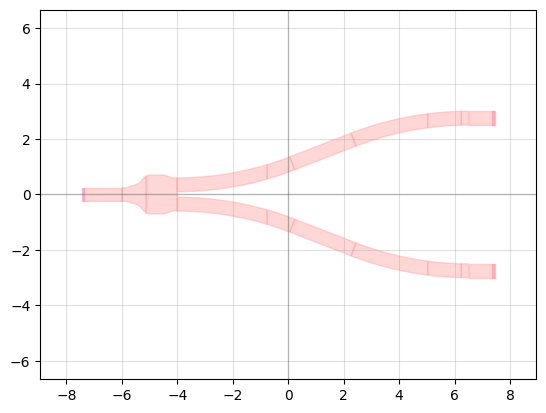

In [76]:
import gdsfactory as gf

filename = "../files/ebeam_y_1550.gds"

# Create a component with the same name as our gds
c = gf.Component(name="ebeam_y_1550") 

# Add the geometry from the gds as a reference to our component
# The << is shorthand for c.add_ref()
splitter = c << gf.read.import_gds(filename)

# Show the component
c.plot_matplotlib()

Now we have a geometry, but in order to use it in gdsfactory, we need ports. We can add these manually, getting the locations from KLayout (you can hover your mouse and read coordinates or examine the polygons vertices themselves and calculate the midpoints):

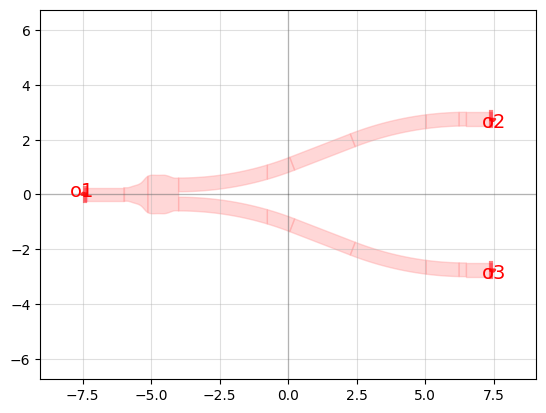

In [77]:
# Add ports. 
c.add_port("o1", center=(-7.4, 0), orientation=180, width=0.5, layer=(1,0))
c.add_port("o2", center=(7.4, 2.75), orientation=0, width=0.5, layer=(1,0))
c.add_port("o3", center=(7.4, -2.75), orientation=0, width=0.5, layer=(1,0))

c.plot_matplotlib()

## Connecting components using ports

We can connect separate components together by referencing ports.

Let's take this straight component:

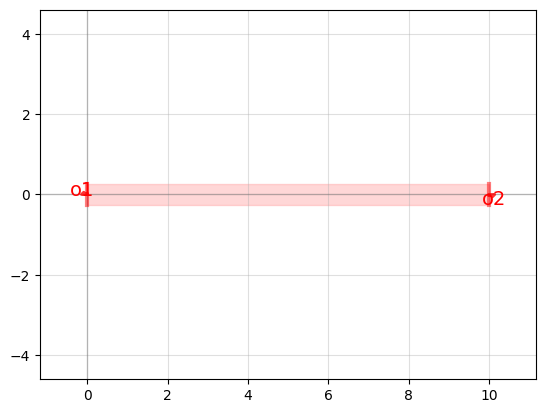

In [4]:
straight = gf.components.straight(length=10)
straight.plot_matplotlib()

and this bend:

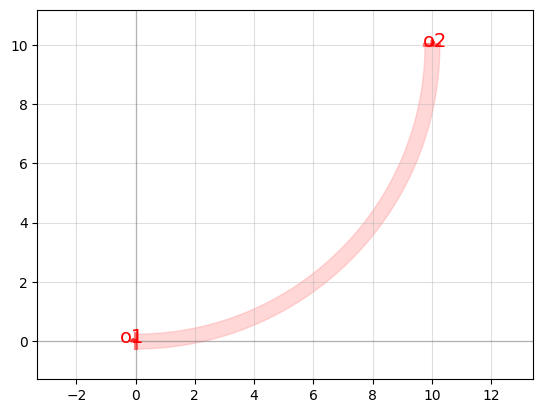

In [7]:
bend = gf.components.bend_circular(radius=10)
bend.plot_matplotlib()

and connect them together. This must be done in a ``Component``, which, if you'll recall, is essentially a canvas on which you can draw your geometry. That includes drawing components, which is what we'll do here by adding references.

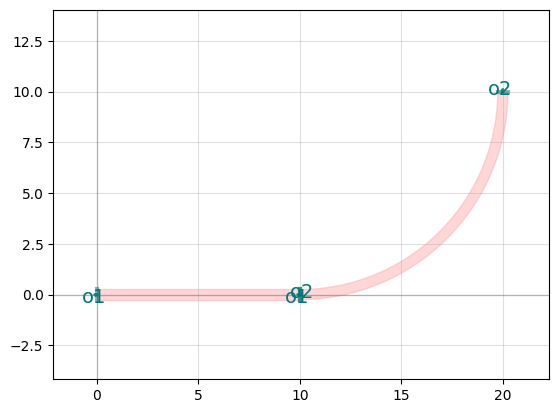

In [10]:
c = gf.Component()

straight_ref = c.add_ref(straight)
bend_ref = c.add_ref(bend)

bend_ref.connect("o1", straight_ref.ports["o2"])

c.plot_matplotlib()

## Exercises

1. Pick a GDS Factory component and recreate it using polygons
1. Use Boolean operators to create a circular ring and then a racetrack ring.
1. Create a directional coupler circuit using only GDS Factory default components